In [1]:
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from cycler import cycler
import palettable
import colorcet as cc

In [2]:
def _load(p):
    if not isinstance(p, list):
        p = [p]
    if len(p) == 1:
        ds = xr.open_dataset(p[0])
    else:
        ds = xr.open_mfdataset(p)
    dv = ds.data_vars
    if 'pr' in dv:
        return dv['pr']
    elif 'PRECT' in dv:
        return dv['PRECT']
    else:
        raise IOError("Could not find pr or PRECT")

In [3]:
def mm2inches(x):
    return x * 0.0393701

In [4]:
#
# We have 3 pieces of information, each in its own file: zonal mean, quantiles, histogram
#
region_string = "tropical" # "nh_extratropics"  #  
p0 = Path("/Volumes/Jedha/")
p1 = p0 / "CMIP6"
p2 = p0 / "cloud_locking"

models = {"CESM2": ('aqua-control', 'aqua-control-lwoff', 'amip', 'amip-lwoff', 'f-cntl', 'f-lock', 'c-cntl', 'c-lock'),
         'CNRM-CM6-1': ('aqua-control', 'aqua-control-lwoff', 'amip', 'amip-lwoff'),
         'IPSL-CM6A-LR': ('aqua-control', 'aqua-control-lwoff', 'amip', 'amip-lwoff'),
         'HadGEM3-GC31-LL': ('aqua-control', 'aqua-control-lwoff', 'amip', 'amip-lwoff'),
         'MRI-ESM2-0': ('amip', 'amip-lwoff'),
         }


locking = {'f-cntl': 'F1850JJB_c201_CTL',
           'f-lock': 'F1850JJB_c201_CLOCK', 
           'c-cntl': 'B1850_c201_CTL',
           'c-lock': 'B1850_c201_CLOCK'}

use_member = {}
for m in models:
    if m == 'CNRM-CM6-1':
        use_member[m] = 'r1i1p1f2'
    elif m == 'HadGEM3-GC31-LL':
        use_member[m] = '*'
    else:
        use_member[m] = 'r1i1p1f1'

ZM = {}  # zonal mean
Q = {}  # quantiles
H = {}  # histogram
for m in models:
    ZM[m] = {}
    Q[m] = {}
    H[m] = {}
    for ex in models[m]:
        if ex in ('aqua-control', 'aqua-control-lwoff', 'amip', 'amip-lwoff'):
            ZM[m][ex] = (86400.) * _load(
                sorted(
                    list(
                        (p1 / "zonal_mean").glob(f'pr_day_{m}_{ex}_{use_member[m]}_ocean.nc'))
                )
            )
            Q[m][ex] = (86400.) * _load( sorted(
                list(
                    (p1 / "quantiles").glob(f'pr_day_{m}_{ex}_{use_member[m]}_{region_string}_ocean.nc'))
                )
            )
            
            H[m][ex] = _load(sorted(list((p1 / "histograms").glob(f'pr_day_{m}_{ex}_{use_member[m]}_{region_string}_ocean.nc'))))
        else:
            # case for locking
            ZM[m][ex] = (86400.*1000.) * _load(p2 / "zonal_mean" / f'PRECT_day_{locking[ex]}_ocean.nc')
            Q[m][ex] = (86400.*1000.) * _load(p2 / "quantiles" / f'PRECT_day_{locking[ex]}_{region_string}_ocean.nc')
            H[m][ex] = _load(p2 / "histograms" / f'PRECT_day_{locking[ex]}_{region_string}_ocean.nc')


            
# pcolors = palettable.colorbrewer.qualitative.Paired_12.mpl_colors
# pcolors = palettable.tableau.Tableau_20_r.mpl_colors
# model_colors = {'CESM2' : {'aqua-control':0, 'aqua-control-lwoff':1, 'amip':0, 'amip-lwoff':1, 'f-cntl':8, 'f-lock':9, 'c-cntl':10, 'c-lock':11},
#                 'CNRM-CM6-1': {'aqua-control':2, 'aqua-control-lwoff':3, 'amip':2, 'amip-lwoff':3},
#                 'IPSL-CM6A-LR': {'aqua-control':4, 'aqua-control-lwoff':5, 'amip':4, 'amip-lwoff':5},
#                 'MRI-ESM2-0': {'amip':6, 'amip-lwoff':7}} 


# This matches extreme_precip_connections figures
model_colors = {}
 # This is the first choice, but gray is index 4, and we want to keep 5&8 for locking (blues)
# for i, m in enumerate(["cesm", "cnrm", "ipsl", "mri", 'hadgem']):
#     model_colors[m] = cc.cm.glasbey_hv(i) 
for i, m in [(0, "cesm"), (1, "cnrm"), (2, "ipsl"), (3, "mri"), (6, "hadgem")]:
    model_colors[m] = cc.cm.glasbey_hv(i) 

# hard code locking to other blues, assumes CESM is first in list.
model_colors['f-lock'] = cc.cm.glasbey_hv(5)
model_colors['f-cntl'] = model_colors['f-lock']
model_colors['c-lock'] = cc.cm.glasbey_hv(8)
model_colors['c-cntl'] = model_colors['c-lock']
# and now `broadcast` it to the actual keys:
mc = {}
for k in ZM:
    mc[k] = {}
    for ex in ZM[k]:
        if ex in model_colors:
            mc[k][ex] = model_colors[ex]
            continue
        else:
            for cmpr in model_colors.keys():
                if cmpr.casefold() in k.casefold():
                    mc[k][ex] = model_colors[cmpr]
                    continue
print(mc)

{'CESM2': {'aqua-control': (0.188235, 0.635294, 0.854902, 1.0), 'aqua-control-lwoff': (0.188235, 0.635294, 0.854902, 1.0), 'amip': (0.188235, 0.635294, 0.854902, 1.0), 'amip-lwoff': (0.188235, 0.635294, 0.854902, 1.0), 'f-cntl': (0.090196, 0.745098, 0.811765, 1.0), 'f-lock': (0.090196, 0.745098, 0.811765, 1.0), 'c-cntl': (0.12156900000000004, 0.466667, 0.705882, 1.0), 'c-lock': (0.12156900000000004, 0.466667, 0.705882, 1.0)}, 'CNRM-CM6-1': {'aqua-control': (0.988235, 0.309804, 0.18823500000000004, 1.0), 'aqua-control-lwoff': (0.988235, 0.309804, 0.18823500000000004, 1.0), 'amip': (0.988235, 0.309804, 0.18823500000000004, 1.0), 'amip-lwoff': (0.988235, 0.309804, 0.18823500000000004, 1.0)}, 'IPSL-CM6A-LR': {'aqua-control': (0.898039, 0.682353, 0.219608, 1.0), 'aqua-control-lwoff': (0.898039, 0.682353, 0.219608, 1.0), 'amip': (0.898039, 0.682353, 0.219608, 1.0), 'amip-lwoff': (0.898039, 0.682353, 0.219608, 1.0)}, 'HadGEM3-GC31-LL': {'aqua-control': (0.580392, 0.403922, 0.741176, 1.0), 'aq

64.99101229626402 7.099331547397178e-05
41.92164319669521 0.000126344806701447
63.77899315617985 7.116781889572288e-05
60.620022461190956 6.638000588382202e-05
74.38617846146391 5.4799169572631675e-05
67.18398141747464 6.505808137995346e-05
71.9332312064551 6.372583994055511e-05
67.80765128678478 6.886354860833954e-05
75.3892779685557 7.113414833774913e-05
74.94293189328168 7.851053558708329e-05
92.81897644847604 4.801178000255338e-05
81.43798150587739 5.910204816563046e-05
85.0400869578125 4.396703206680427e-05
49.2609112763781 5.615256816777294e-05
105.60434664934897 3.3548000599071436e-05
56.963873684409194 5.902324320288263e-05
72.37434206362822 6.833547131472129e-05
56.32546365894416 8.069550118411974e-05
102.1732870560149 3.2119196319177544e-05
83.67937963307061 3.74365543189202e-05
65.60644887462311 6.076778950192279e-05
49.52737932913028 9.701341953741626e-05


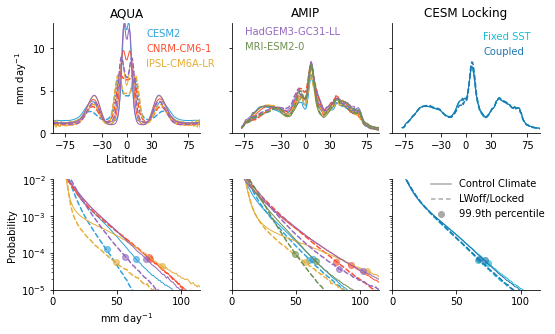

In [13]:

# I want to have 3 columns that show:
# |-- aqua --|-- amip --|-- lock --|

# 2 rows: zonal mean and histogram

fig, axx = plt.subplots(figsize=(mm2inches(190), mm2inches(115)), ncols=3, nrows=2, constrained_layout=True)
# [a.set_prop_cycle('color', palettable.colorbrewer.qualitative.Paired_12.mpl_colors) for a in axx.ravel()]

all_lines = []
line_holder = []  # to customize legend later
labl_holder  = []
ax = axx[0,:]
for m in ZM:
    leglabel = m
    for ex in ZM[m]:
        clr = mc[m][ex]
        xlat = ZM[m][ex]['lat']
        xzm = ZM[m][ex]
        if "aqua" in ex:
            panel = 0
        elif "amip" in ex:
            panel = 1
            labl_holder.append(leglabel)  # holds just the amip labels
        else:
            panel = 2
            leglabel = ex
        if ('lock' in ex) or ('off' in ex):
            linsty = (0, (3,2))
            lw = 1.5
        else:
            linsty = 'solid'
            lw = 1
        all_lines.append(ax[panel].plot(xlat, xzm, label=leglabel, color=clr, linestyle=linsty, linewidth=lw, dash_capstyle = "round"))
        if panel == 1:
            line_holder.append(all_lines[-1][0])
[a.set_xlim([-90, 90]) for a in ax]
[a.set_ylim([0,13]) for a in ax]
[a.spines['top'].set_visible(False) for a in ax]
[a.spines['right'].set_visible(False) for a in ax]
[a.set_yticklabels([]) for i, a in enumerate(ax) if i > 0 ]
[a.set_xticks([-75, -30, 0, 30, 75]) for i, a in enumerate(ax)]
titles = ["AQUA", "AMIP", "CESM Locking"]
[a.set_title(titles[i]) for i, a in enumerate(ax)]
ax[0].set_ylabel("mm day$^{-1}$")
ax[0].set_xlabel("Latitude")



ax = axx[1,:]
for m in H:
    for ex in H[m]:
        clr = mc[m][ex]
        xlat = H[m][ex]['bins']
        y = H[m][ex]
        if "aqua" in ex:
            panel = 0
        elif "amip" in ex:
            panel = 1
        else:
            panel = 2
        if ('lock' in ex) or ('off' in ex):
            linsty = (0, (3, 2))
            lw = 1.5
        else:
            linsty = 'solid'
            lw = 1
        ax[panel].plot(xlat, y, label=m, color=clr, linestyle=linsty, linewidth=lw, dash_capstyle='round')
        # ADD DOT AT SELECTED QUANTILE:
        pct = Q[m][ex].sel(quantile=0.999).item()
        nearest_idx = np.abs(xlat - pct).argmin().item()
        ax[panel].plot(pct, y[nearest_idx], marker='o', color=clr, markersize=6, alpha=0.6)
        print(pct, y[nearest_idx].item())
        
[a.semilogy() for a in axx[1,:]]
[a.spines['top'].set_visible(False) for a in ax]
[a.spines['right'].set_visible(False) for a in ax]
[a.set_ylim([1e-5,1e-2]) for a in ax]
[a.set_xlim([0,115]) for a in ax]
[a.set_yticklabels([]) for i, a in enumerate(ax) if i > 0 ]
ax[0].set_ylabel("Probability")
ax[0].set_xlabel("mm day$^{-1}$")
# ax[-1].text(30, 3e-3, "dots: 99.9th percentile")


leg0 = axx[0,0].legend(line_holder[1:6:2], labl_holder[1:6:2], ncol=1, handlelength=0, frameon=False, loc=(.55, .55))
leg1 = axx[0,1].legend(line_holder[7::2], labl_holder[7::2], ncol=1, handlelength=0,frameon=False, loc=(.01,.7))
# leg1 = axx[0,1].legend(line_holder[1::2], labl_holder[1::2], ncol=2, handlelength=0,frameon=False, loc=(.01,.5))
# # change the font colors to match the line colors:
for line,text in zip(leg0.get_lines(), leg0.get_texts()):
    text.set_color(line.get_color())
for line,text in zip(leg1.get_lines(), leg1.get_texts()):
    text.set_color(line.get_color())


# leg2 = axx[0,-1].legend(handlelength=0,frameon=False, ncol=2)
# # change the font colors to match the line colors:
# for line,text in zip(leg2.get_lines(), leg2.get_texts()):
#     text.set_color(line.get_color())
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker="None", linestyle="None", color=model_colors['f-cntl'], label='Fixed SST'),
                   Line2D([0], [0], marker="None", linestyle="None", color=model_colors['c-cntl'], label='Coupled'),                   
                  ]

axx[0,-1].legend(handles=legend_elements, loc='upper right', labelcolor='linecolor', frameon=False)

# A key in the final axes:
legend_elements_last = [Line2D([0], [0], marker="None", linestyle="solid", color="darkgray", label='Control Climate'),
                        Line2D([0], [0], marker="None", linestyle=linsty, color="darkgray", label='LWoff/Locked'),                                      
                        Line2D([0], [0], marker="o", linestyle="None", color="darkgray", label='99.9th percentile'),                   
                  ]

# axx[-1,-1].legend(handles=legend_elements_last, loc='upper right', bbox_to_anchor=(1.1, 1.2), frameon=False)
fig.legend(handles=legend_elements_last, loc='upper right', bbox_to_anchor=(1.02, 0.49), frameon=False)


# fig.suptitle(region_string)
fig.savefig(f"/Users/brianpm/Dropbox/Apps/Overleaf/cre_pex/amip_aqua_locking_zonal_and_pdf_{region_string}_withHadGEM.pdf", bbox_inches='tight')

In [32]:
arr = prq.sel(lat=slice(slat,nlat)).values.flatten()
not_missing = np.logical_not(np.isnan(arr))
ans = np.quantile(arr[not_missing], quantiles)
ans = xr.DataArray(ans, dims=("quantile"), coords={"quantile":quantiles}, name="PRECT", attrs=data.attrs)

NameError: name 'prq' is not defined

In [17]:
arr.shape

(168210432,)

In [18]:
arr[not_missing].shape

(119167308,)

In [19]:
ans

<xarray.DataArray 'PRECT' (quantile: 101)>
array([3.31105004e-21, 1.12013554e-15, 1.20012881e-12, 5.89247992e-12,
       1.96774484e-11, 5.28624575e-11, 1.04901456e-10, 1.76030835e-10,
       2.65744007e-10, 3.70871492e-10, 4.87886471e-10, 6.14046480e-10,
       7.47008788e-10, 8.84461114e-10, 1.02490006e-09, 1.16706378e-09,
       1.31001571e-09, 1.45364290e-09, 1.59719504e-09, 1.74089010e-09,
       1.88462156e-09, 2.02908956e-09, 2.17457208e-09, 2.32116104e-09,
       2.46978016e-09, 2.62034749e-09, 2.77367351e-09, 2.93009239e-09,
       3.09052984e-09, 3.25544705e-09, 3.42606902e-09, 3.60312635e-09,
       3.78751075e-09, 3.98011402e-09, 4.18237978e-09, 4.39612036e-09,
       4.62301690e-09, 4.86529735e-09, 5.12560527e-09, 5.40550316e-09,
       5.70617281e-09, 6.02737901e-09, 6.36759445e-09, 6.72674542e-09,
       7.10540071e-09, 7.50219906e-09, 7.91746579e-09, 8.35247459e-09,
       8.80625883e-09, 9.27958688e-09, 9.77308507e-09, 1.02863771e-08,
       1.08213305e-08, 1.13803420e-08, 1.19633440e-08, 1.25734623e-08,
       1.32129552e-08, 1.38836036e-08, 1.45913868e-08, 1.53384864e-08,
       1.61294906e-08, 1.69702871e-08, 1.78638260e-08, 1.88184259e-08,
       1.98407015e-08, 2.09370956e-08, 2.21152726e-08, 2.33850539e-08,
       2.47563463e-08, 2.62355165e-08, 2.78336749e-08, 2.95607450e-08,
       3.14387951e-08, 3.34829799e-08, 3.57148551e-08, 3.81548304e-08,
       4.08202140e-08, 4.37321930e-08, 4.69058783e-08, 5.03522912e-08,
       5.41007192e-08, 5.81704782e-08, 6.25955509e-08, 6.74162300e-08,
       7.26949946e-08, 7.84894284e-08, 8.48935571e-08, 9.20306758e-08,
       1.00043858e-07, 1.09143215e-07, 1.19624232e-07, 1.31936417e-07,
       1.46672626e-07, 1.64835819e-07, 1.88063603e-07, 2.19167585e-07,
       2.63020269e-07, 3.29531161e-07, 4.48068767e-07, 8.60951140e-07,
       1.66021959e-06])
Coordinates:
  * quantile  (quantile) float64 0.01 0.02 0.03 0.04 ... 0.98 0.99 0.999 0.9999
Attributes:
    units:         m/s
    long_name:     Total (convective and large-scale) precipitation rate (liq...
    cell_methods:  time: mean

In [20]:
lds = xr.open_dataset('/Volumes/Glyph6TB/CMIP6/sftlf_fx_CESM2_amip_r10i1p1f1_gn.nc')
lds

/Users/brianpm/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/conventions.py:490: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:   (lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: nbnd
Data variables:
    sftlf     (lat, lon) float32 ...
    lat_bnds  (lat, nbnd) float64 ...
    lon_bnds  (lon, nbnd) float64 ...
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          no parent
    branch_time_in_child:   711385.0
    branch_time_in_parent:  0.0
    case_id:                1587
    cesm_casename:          f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.010
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2019-11-21T12:55:17Z
    data_specs_version:     01.00.31
    experiment:             An atmosphere only climate simulation using presc...
    experiment_id:          amip
    external_variables:     areacella
    forcing_index:          1
    frequency:              fx
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NCAR.CESM2.a...
    grid:                   native 0.9x1.25 finite volume grid (192x288 latxlon)
    grid_label:             gn
    initialization_index:   1
    institution:            National Center for Atmospheric Research, Climate...
    institution_id:         NCAR
    license:                CMIP6 model data produced by <The National Center...
    mip_era:                CMIP6
    model_doi_url:          https://doi.org/10.5065/D67H1H0V
    nominal_resolution:     100 km
    parent_activity_id:     no parent
    parent_experiment_id:   no parent
    parent_mip_era:         no parent
    parent_source_id:       no parent
    parent_time_units:      no parent
    parent_variant_label:   no parent
    physics_index:          1
    product:                model-output
    realization_index:      10
    realm:                  atmos
    source:                 CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite v...
    source_id:              CESM2
    source_type:            AGCM BGC AER
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               fx
    tracking_id:            hdl:21.14100/fa21bd4a-69b0-45d7-a2ef-5f134b6fb56e
    variable_id:            sftlf
    variant_info:           CMIP6 CESM2 AMIP hindcast (1950-2014) with intera...
    variant_label:          r10i1p1f1

In [21]:
lds['sftlf']

<xarray.DataArray 'sftlf' (lat: 192, lon: 288)>
array([[100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean
    comment:        LANDFRAC[0,:,:]
    description:    Percentage of horizontal area occupied by land.
    frequency:      fx
    id:             sftlf
    long_name:      Percentage of the grid  cell occupied by land (including ...
    mipTable:       fx
    out_name:       sftlf
    prov:           fx ((isd.003))
    realm:          atmos
    standard_name:  land_area_fraction
    time_label:     None
    time_title:     No temporal dimensions ... fixed field
    title:          Percentage of the grid  cell occupied by land (including ...
    type:           real
    units:          %
    variable_id:    sftlf

In [36]:
bedg = np.arange(0, 100, 1)
bctr = bedg[0:-1] + np.diff(bedg)/2
bctr

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
       22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
       33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
       44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5,
       55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5, 62.5, 63.5, 64.5, 65.5,
       66.5, 67.5, 68.5, 69.5, 70.5, 71.5, 72.5, 73.5, 74.5, 75.5, 76.5,
       77.5, 78.5, 79.5, 80.5, 81.5, 82.5, 83.5, 84.5, 85.5, 86.5, 87.5,
       88.5, 89.5, 90.5, 91.5, 92.5, 93.5, 94.5, 95.5, 96.5, 97.5, 98.5])

In [42]:
tsth = np.histogram(arr[not_missing], bins=bedg/(86400/1000))
tsth

(array([119167308,         0,         0,         0,         0,         0,
                0,         0,         0,         0,         0,         0,
                0,         0,         0,         0,         0,         0,
                0,         0,         0,         0,         0,         0,
                0,         0,         0,         0,         0,         0,
                0,         0,         0,         0,         0,         0,
                0,         0,         0,         0,         0,         0,
                0,         0,         0,         0,         0,         0,
                0,         0,         0,         0,         0,         0,
                0,         0,         0,         0,         0,         0,
                0,         0,         0,         0,         0,         0,
                0,         0,         0,         0,         0,         0,
                0,         0,         0,         0,         0,         0,
                0,         0,         

In [36]:
palettable.colorbrewer.qualitative.Paired_12.mpl_colors

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [10]:
mypngs = (Path("/Users/brianpm/Desktop/").glob("*.png"))
type(mypngs)

generator

In [12]:
type(mypngs) == 'generator'

False